# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [54]:
# imports
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# general params

# calibration grid size
nx = 9
ny = 6
# calibration pickle filename
cal_fname = 'calibration.pkl'
# output image folder
output_folder = 'output_images/'

## Camera calibration

In [23]:
# get all camera calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# initialize object points (these stay const)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# enumerate over each image and add image points to array
for idx, fname in enumerate(fnames):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)
    else:
        print('No corners found for {}'.format(fname))

No corners found for camera_cal/calibration5.jpg
No corners found for camera_cal/calibration4.jpg
No corners found for camera_cal/calibration1.jpg


In [35]:
# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
# save calibration
with open(cal_fname, 'wb') as cal_file:
    pickle.dump((mtx, dist), cal_file)

In [41]:
# retrive calibration and undistort
camera_matrix, distortion_coff = None, None
with open(cal_fname, 'rb') as cal_file:
    camera_matrix, distortion_coff = pickle.load(cal_file)
print('Camera_matrix:')
print(camera_matrix)
print('Distortion coefficients:')
print(distortion_coff)

Camera_matrix:
[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]


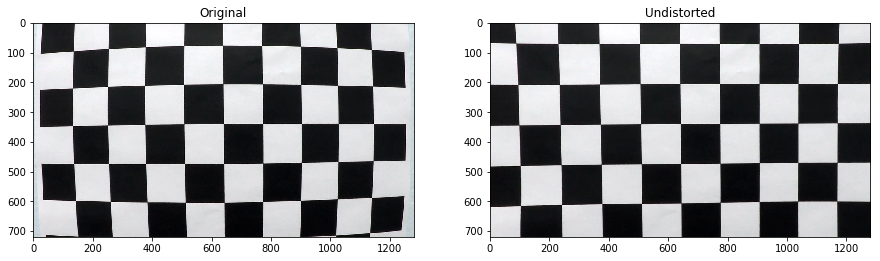

In [57]:
# undistort sample image
# note this image was not used for calibration because all corners could not be found
img = cv2.imread('camera_cal/calibration1.jpg')
# undistort image
dst = cv2.undistort(img, camera_matrix, distortion_coff, None, camera_matrix)
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(img)
plt.subplot(122)
plt.title('Undistorted')
plt.imshow(dst)
plt.savefig(os.path.join(output_folder, 'calibration.jpg'), bbox_inches='tight')
plt.show()